### Setup

In [5]:
from wearsed.dataset.Recording import Recording
import matplotlib.pyplot as plt
from lxml import etree
import pandas as pd

In [86]:
translate = {
    'Wake': 0,
    'NonREM1': 1,
    'NonREM2': 2,
    'NonREM3': 3,
    'REM': 5
}

def read_somnolyzer(mesa_id):
    root = etree.parse(f'/vol/sleepstudy/datasets/mesa/somnolyzer_scorings/mesa-sleep-{mesa_id:04}.rml').getroot()
    scoring_root = root.find('{http://www.respironics.com/PatientStudy.xsd}ScoringData')

    hypnogram = read_hypnogram(scoring_root.find('{http://www.respironics.com/PatientStudy.xsd}StagingData').find('{http://www.respironics.com/PatientStudy.xsd}MachineStaging').find('{http://www.respironics.com/PatientStudy.xsd}NeuroAdultAASMStaging'))
    events = read_events(scoring_root.find('{http://www.respironics.com/PatientStudy.xsd}Events'))
    
    return hypnogram, events

def read_hypnogram(hypnogram_scoring_root):
    stages = []
    for child in hypnogram_scoring_root:
        stages.append(child.attrib)
        
    hypnogram = pd.Series(0, index=range(int(stages[-1]['Start'])))

    for a, b in zip(stages, stages[1:]):
        stage = translate[a['Type']]
        start = int(a['Start'])
        end   = int(b['Start'])
        hypnogram[start:end] = stage
    
    return hypnogram

def read_events(events_root):
    events = []
    for ev in events_root:
        ev = ev.attrib
        if ev['Family'] == 'Respiratory':
            event_type = ev['Type']
            if event_type in ['Hypopnea', 'ObstructiveApnea', 'CentralApnea', 'MixedApnea']:
                event_start = int(float(ev['Start']))
                event_end = event_start + int(float(ev['Duration']))
                events.append({'Type': event_type, 'Start': event_start, 'End': event_end})
    return events

def comp_hypnogram(mesa_id):
    nsrr = Recording(mesa_id, signals_to_read=[]).hypnogram
    somnolyzer,_ = read_somnolyzer(mesa_id)

    _, axs = plt.subplots(2, 1, figsize=(20, 4), sharex=True)

    nsrr.plot(ax=axs[0])
    somnolyzer.plot(ax=axs[1])

    axs[0].legend(['NSRR'], loc='upper right')
    axs[1].legend(['Somnolyzer'], loc='upper right')
    
    axs[0].grid()
    axs[1].grid()

    plt.tight_layout()
    plt.show()
    

### Hypnogram

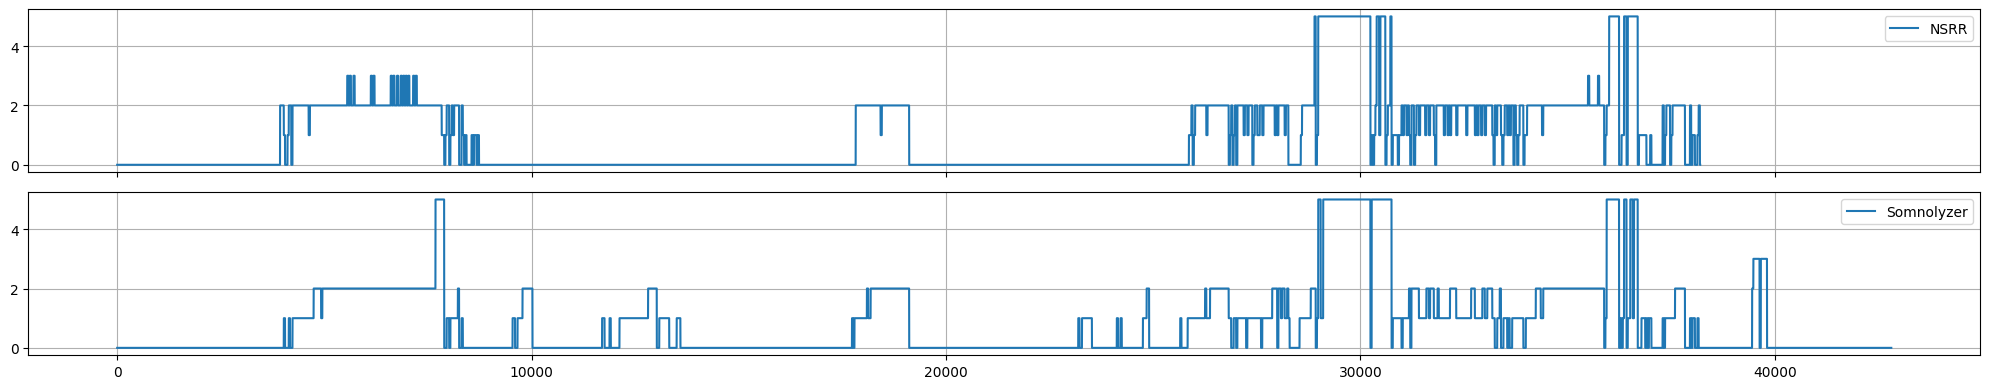

In [87]:
comp_hypnogram(12)

### Events

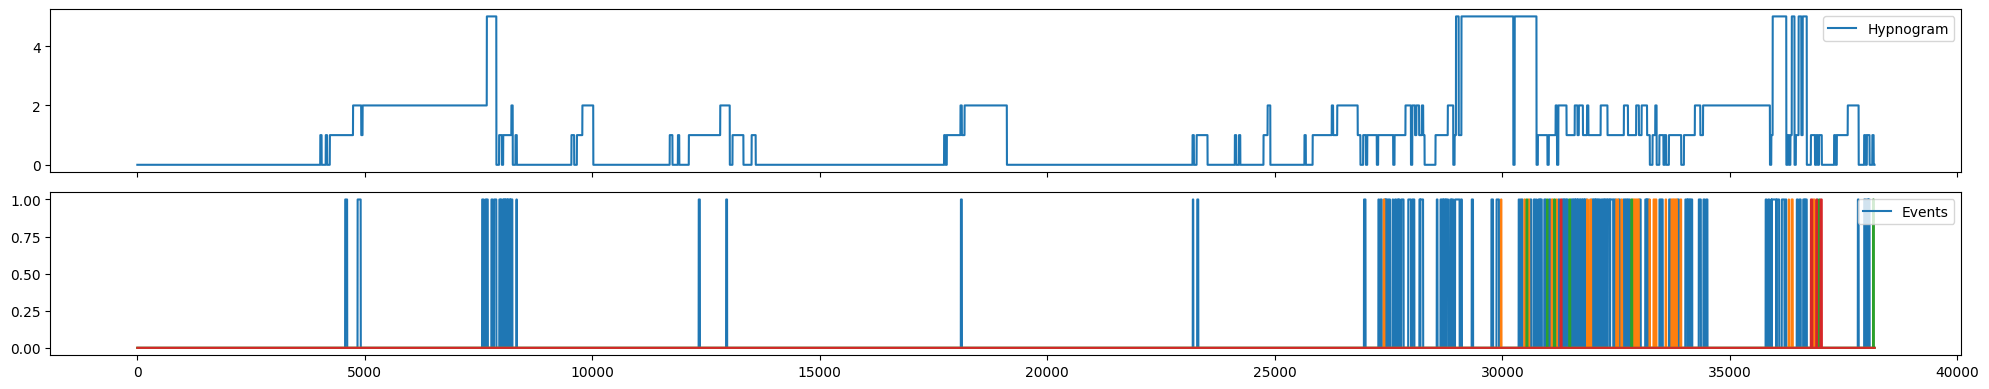

In [70]:
hyp, evs = read_somnolyzer(12)

event_df = pd.DataFrame(0, index=range(len(hyp)), columns=['Hypopnea', 'ObstructiveApnea', 'CentralApnea', 'MixedApnea']) 
for ev in evs:
    event_df.loc[ev['Start']:ev['End'], ev['Type']] = 1
event_df[(hyp == 0)] = 0

_, axs = plt.subplots(2, 1, figsize=(20, 4), sharex=True)

hyp[:38180].plot(ax=axs[0])
event_df.iloc[:38180].plot(ax=axs[1])

axs[0].legend(['Hypnogram'], loc='upper right')
axs[1].legend(['Events'], loc='upper right')

plt.tight_layout()
plt.show()

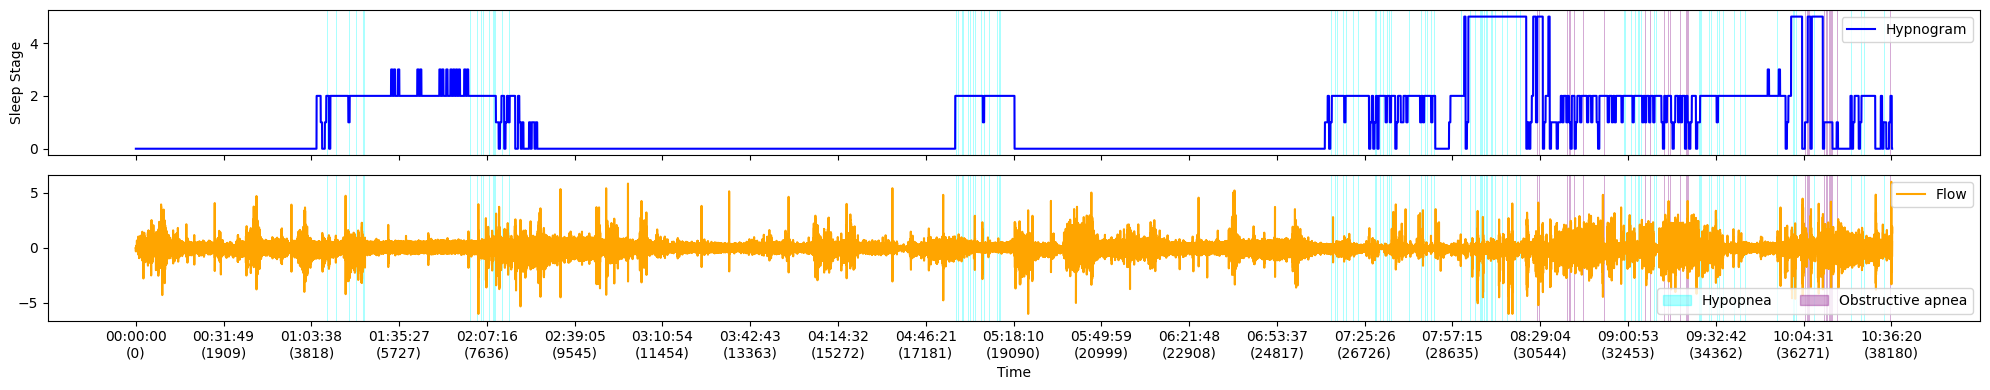

In [92]:
Recording(12, signals_to_read=['Flow']).look_at(events=['Hypopnea', 'Obstructive apnea', 'Central apnea'])

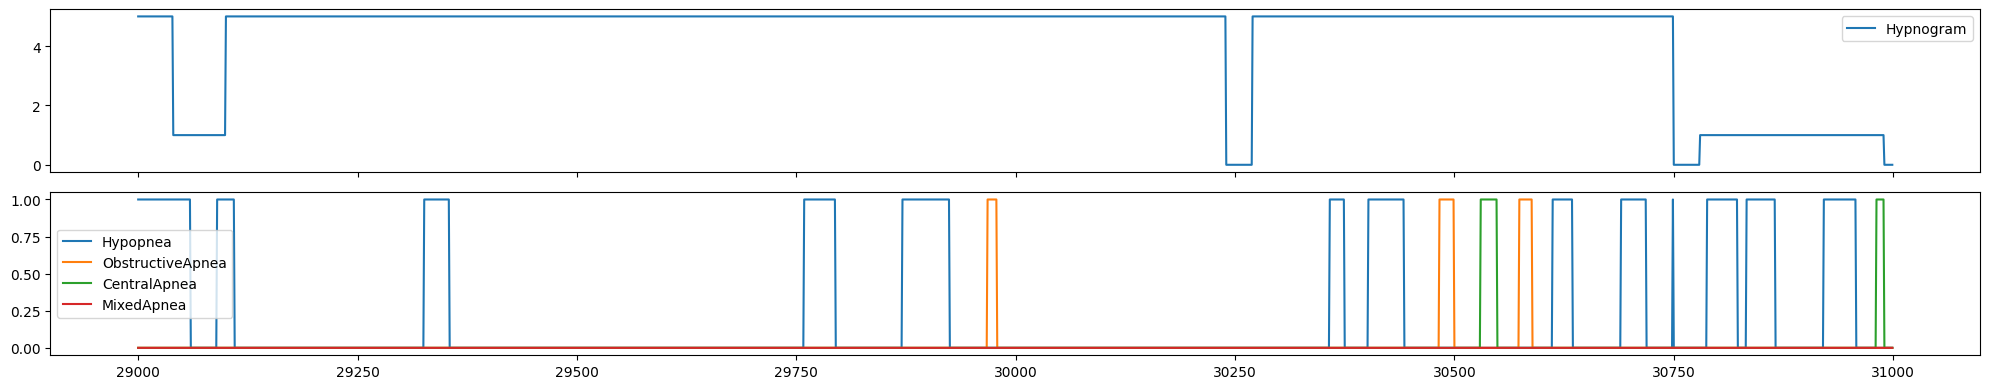

In [103]:
time, window_size = 30000, 1000

_, axs = plt.subplots(2, 1, figsize=(20, 4), sharex=True)

hyp[time-window_size:time+window_size].plot(ax=axs[0])
event_df.iloc[time-window_size:time+window_size].plot(ax=axs[1])

axs[0].legend(['Hypnogram'], loc='upper right')

plt.tight_layout()
plt.show()

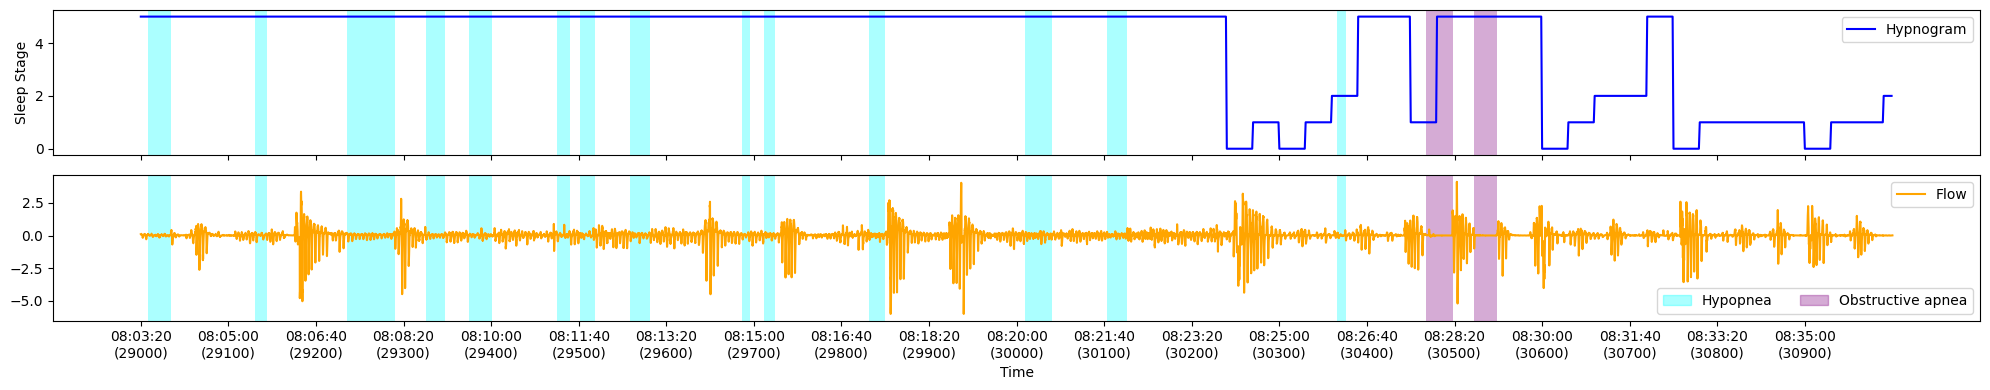

In [104]:
Recording(12, signals_to_read=['Flow']).look_at(time=time, window_size=window_size, events=['Hypopnea', 'Obstructive apnea', 'Central apnea'])

### Analyse Event Families

In [13]:
import os
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [14]:
scoring_dir = '/vol/sleepstudy/datasets/mesa/somnolyzer_scorings/'

all_events = []

for f in tqdm(os.listdir(scoring_dir)):
    person = scoring_dir + f
    root = etree.parse(person).getroot()
    scoring_root = root.find('{http://www.respironics.com/PatientStudy.xsd}ScoringData')
    events = scoring_root.find('{http://www.respironics.com/PatientStudy.xsd}Events')
    for ev in events:
        all_events.append(ev.attrib)


00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1893/1893 [00:35<00:00, 53.95it/s]

4669427
Counter({'Cardiac': 2281512, 'User': 1249869, 'Respiratory': 433726, 'Neuro': 353419, 'SpO2': 350901})


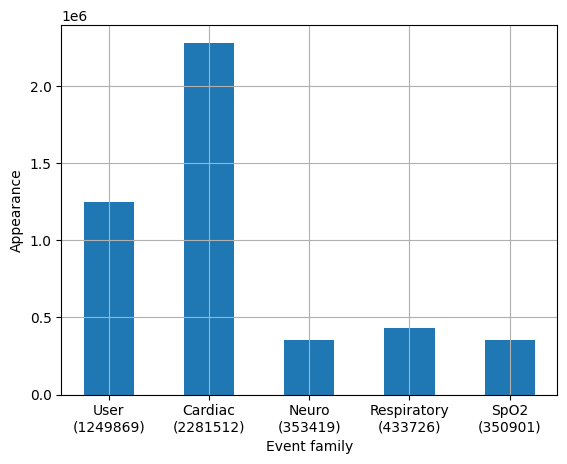

In [15]:
print(len(all_events))

all_events_families = [ev['Family'] for ev in all_events]
families = Counter(all_events_families)
print(families)

fig, ax = plt.subplots()
ax.bar([f'{k}\n({v})' for k, v in zip(families.keys(), families.values())], families.values(), 0.5, label='xxxx')
ax.set_xlabel('Event family')
ax.set_ylabel('Appearance')
ax.grid()
plt.show()

In [20]:
def analyse_event_set(event_family):
    events_filt = list(filter(lambda ev: ev['Family'] == event_family, all_events))
    keys = [ev.keys() for ev in events_filt]
    keys_flatten = []
    for key_list in keys:
        keys_flatten += key_list
    print(Counter(keys_flatten))
    print(Counter([ev['Type'] for ev in events_filt]))

In [21]:
analyse_event_set('User')

Counter({'Family': 1249869, 'Type': 1249869, 'Start': 1249869, 'Duration': 1249869, 'Machine': 1249869, 'EdfSignal': 1249869})
Counter({'ChannelFail': 1249869})


In [22]:
analyse_event_set('Cardiac')

Counter({'Family': 2281512, 'Type': 2281512, 'Start': 2281512, 'Duration': 2281512, 'Machine': 2281512})
Counter({'LongRR': 1886560, 'Bradycardia': 317123, 'Tachycardia': 77829})


In [23]:
analyse_event_set('Neuro')

Counter({'Family': 353419, 'Type': 353419, 'Start': 353419, 'Duration': 353419, 'EMGIncrease': 353419, 'Machine': 353419})
Counter({'Arousal': 353419})


In [24]:
analyse_event_set('Respiratory')

Counter({'Family': 433726, 'Type': 433726, 'Start': 433726, 'Duration': 433726, 'Machine': 433726, 'EdfSignal': 432380, 'EMGIncrease': 38751})
Counter({'Hypopnea': 262010, 'ObstructiveApnea': 95742, 'RERA': 38751, 'CentralApnea': 29043, 'MixedApnea': 6834, 'CheyneStokesRespiration': 1346})


In [25]:
analyse_event_set('SpO2')

Counter({'Family': 350901, 'Type': 350901, 'Start': 350901, 'Duration': 350901, 'Machine': 350901})
Counter({'RelativeDesaturation': 350901})


In [27]:
events_filt = list(filter(lambda ev: ev['Family'] == 'Respiratory', all_events))
events_filt

[{'Family': 'Respiratory', 'Type': 'RERA', 'Start': '110', 'Duration': '60', 'EMGIncrease': '3.16', 'Machine': 'true', 'EdfSignal': '8'},
 {'Family': 'Respiratory', 'Type': 'CentralApnea', 'Start': '285.5', 'Duration': '10.5', 'Machine': 'true', 'EdfSignal': '8'},
 {'Family': 'Respiratory', 'Type': 'Hypopnea', 'Start': '749.5', 'Duration': '31.5', 'Machine': 'true', 'EdfSignal': '8'},
 {'Family': 'Respiratory', 'Type': 'Hypopnea', 'Start': '1017.5', 'Duration': '12', 'Machine': 'true', 'EdfSignal': '8'},
 {'Family': 'Respiratory', 'Type': 'Hypopnea', 'Start': '1401.5', 'Duration': '29', 'Machine': 'true', 'EdfSignal': '8'},
 {'Family': 'Respiratory', 'Type': 'Hypopnea', 'Start': '1557', 'Duration': '43', 'Machine': 'true', 'EdfSignal': '8'},
 {'Family': 'Respiratory', 'Type': 'Hypopnea', 'Start': '1689.5', 'Duration': '28', 'Machine': 'true', 'EdfSignal': '8'},
 {'Family': 'Respiratory', 'Type': 'Hypopnea', 'Start': '1766', 'Duration': '13', 'Machine': 'true', 'EdfSignal': '8'},
 {'Fam